# First of All

In [1]:
import requests
import zipfile
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

# ZIP Downloader

In [4]:
class ZipDownloader:
    def __init__(self, url, download_path, extract_path):
        self.url = url
        self.download_path = download_path
        self.extract_path = extract_path

    def download_zip(self):
        response = requests.get(self.url)
        if response.status_code == 200:
            with open(self.download_path, 'wb') as file:
                file.write(response.content)
            print(f"Downloaded zip file to {self.download_path}")
        else:
            print(f"Failed to download zip file. Status code: {response.status_code}")

    def extract_zip(self):
        if not os.path.exists(self.extract_path):
            os.makedirs(self.extract_path)

        with zipfile.ZipFile(self.download_path, 'r') as zip_ref:
            zip_ref.extractall(self.extract_path)
        print(f"Extracted zip file to {self.extract_path}")

## Set

In [5]:
url = "https://github.com/ridwaanhall/datasets/raw/main/english_handwritten_characters.zip"
download_path = "/content/english_handwritten_characters.zip"
extract_path = "/content/english_handwritten_characters"

In [6]:
zip_downloader = ZipDownloader(url, download_path, extract_path)

## Download and Extract

In [7]:
zip_downloader.download_zip()

Downloaded zip file to /content/english_handwritten_characters.zip


In [8]:
zip_downloader.extract_zip()

Extracted zip file to /content/english_handwritten_characters


# Check Image

In [9]:
test_data = '/content/english_handwritten_characters/english.csv'
df = pd.read_csv(test_data)

In [10]:
df["label"].value_counts()

,count
label,
0,55
1,55
2,55
3,55
4,55
5,55
6,55
7,55
8,55


In [11]:
images_path = '/content/english_handwritten_characters/Img'

# List to hold the dimensions of all images
image_sizes = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path)
    if image is not None:
        height, width = image.shape[:2]
        image_sizes.append((width, height))

# Print the size of the first image
if image_sizes:
    print("Size of the first image:", image_sizes[1])
    print("Unique image sizes:", set(image_sizes))
else:
    print("No images found in the directory.")

Size of the first image: (1200, 900)
Unique image sizes: {(1200, 900)}


In [12]:
images_path = '/content/english_handwritten_characters/Img'
images = []
labels = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path).astype('float32')
    image = cv.resize(image, (64, 64))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #image = cv.GaussianBlur(image, (1, 1), 0)
    image /= 255.0
    label_index = os.path.join("Img", image_file)
    label = df[df['image'] == label_index].label.values[0]
    images.append(image)
    labels.append(label)

    # Create inverted image
    inverted_image = 1.0 - image
    images.append(inverted_image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

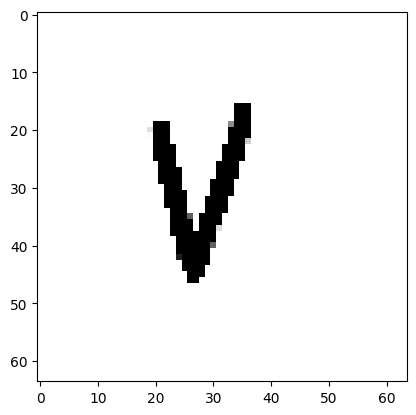

In [13]:
plt.gray()
plt.imshow(images[112])

In [14]:
print("Number of images:", len(images))
print("Shape of each image:", images.shape[1:])
print("Unique labels:", np.unique(labels))

Number of images: 6820
Shape of each image: (64, 64)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [15]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [16]:
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

In [17]:
images, labels = shuffle(images, labels, random_state=0)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define an exponential decay learning rate schedule function
def exponential_decay(epoch, lr):
    initial_lr = 0.001
    k = 0.1
    decay_rate = k ** (epoch / 10)
    return initial_lr * decay_rate

In [19]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [20]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [21]:
# Initialize lists to hold augmented images and labels
augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

# Iterate over each image in X_train
for i in range(len(X_train)):
    # Ensure the image has the correct shape (height, width, channels)
    image = X_train[i]
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)  # Convert (height, width) to (height, width, channels)

    # Expand dimensions to include batch size
    image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)

    # Create iterator for augmented images
    aug_iter = datagen.flow(image_expanded, batch_size=1)

    # Generate augmented images
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]

    # Extend the list with the new augmented images and corresponding labels
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

# Convert lists to numpy arrays
augmented_arr_X = np.array(augmented_arr_X)
augmented_arr_Y = np.array(augmented_arr_Y)

print("Augmented images shape:", augmented_arr_X.shape)
print("Augmented labels shape:", augmented_arr_Y.shape)

Augmented images shape: (23870, 64, 64, 1)
Augmented labels shape: (23870, 62)


In [22]:
X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [23]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

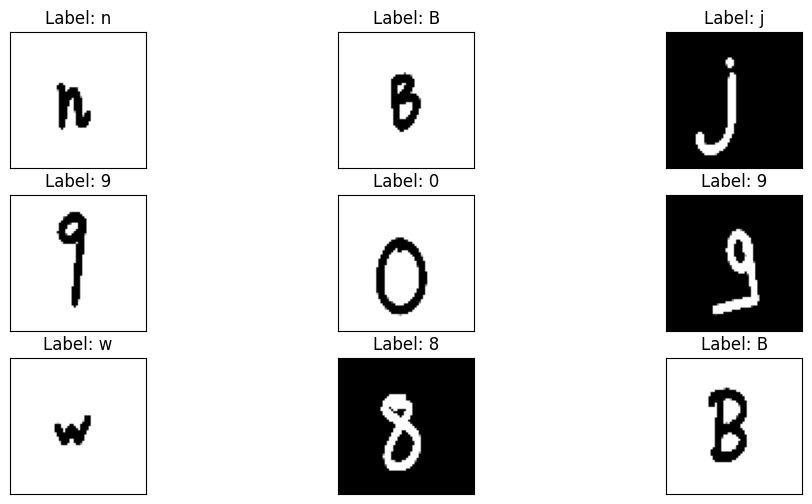

In [39]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")

display_images(3, 3, images, labels, decoder)

In [25]:
num_classes = len(np.unique(labels))  # Check how many unique labels you have
print("Number of classes:", num_classes)

Number of classes: 2


In [26]:
model = Sequential([
    Input(shape=(64, 64, 1)),

    Conv2D(512, (5, 5), activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(1024, activation='relu'),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='sigmoid'),

    Dense(62, activation='softmax')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 512)       13312     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0

In [28]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (23870, 64, 64, 1)
Shape of X_val: (1023, 64, 64)
Shape of X_test: (1023, 64, 64)


In [29]:
import tensorflow as tf

from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy

# Create a mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks here
)

Epoch 1/50
746/746 [==============================] - 37s 39ms/step - loss: 3.7222 - accuracy: 0.0824 - val_loss: 2.9289 - val_accuracy: 0.2190 - lr: 1.0000e-04
Epoch 2/50
746/746 [==============================] - 26s 35ms/step - loss: 2.6216 - accuracy: 0.3067 - val_loss: 1.8790 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 3/50
746/746 [==============================] - 26s 35ms/step - loss: 1.8091 - accuracy: 0.5263 - val_loss: 1.2298 - val_accuracy: 0.6784 - lr: 1.0000e-04
Epoch 4/50
746/746 [==============================] - 27s 37ms/step - loss: 1.2977 - accuracy: 0.6495 - val_loss: 0.9570 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 5/50
746/746 [==============================] - 28s 38ms/step - loss: 1.0067 - accuracy: 0.7173 - val_loss: 0.7972 - val_accuracy: 0.7498 - lr: 1.0000e-04
Epoch 6/50
746/746 [==============================] - 28s 37ms/step - loss: 0.8255 - accuracy: 0.7574 - val_loss: 0.6804 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 7/50
746/746 [==============

In [30]:
model.save('zeronine_en_char.h5')
print("Model saved as 'zeronine_en_char.h5'")

Model saved as 'zeronine_en_char.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from google.colab import files
import numpy as np

In [32]:
class ImagePredictor:
    def __init__(self, model_path, decoder):
        self.model = self.load_model(model_path)
        self.decoder = decoder

    def load_model(self, model_path):
        try:
            model = load_model(model_path)
            print(f"Model loaded successfully from '{model_path}'")
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

    def preprocess_image(self, image_path):
        img = keras_image.load_img(image_path, target_size=(64, 64), color_mode='grayscale')
        img_array = keras_image.img_to_array(img)
        img_array = img_array.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array, img

    def predict_and_show(self, image_path):
        img_array, img = self.preprocess_image(image_path)
        predictions = self.model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        decoded_label = self.decoder[predicted_class]
        print(f"Predicted label for {image_path}: {decoded_label}")

        # Display the uploaded image with prediction
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted label: {decoded_label}")
        plt.axis('off')
        plt.show()

In [33]:
# Usage
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]
image_predictor = ImagePredictor('zeronine_en_char.h5', decoder)

Model loaded successfully from 'zeronine_en_char.h5'


Saving Screenshot 2024-07-31 182848.png to Screenshot 2024-07-31 182848.png
1/1 [==============================] - 0s 405ms/step
Predicted label for Screenshot 2024-07-31 182848.png: 4


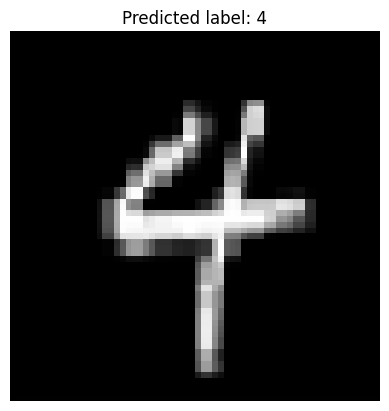

In [34]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)

Saving Screenshot 2024-07-31 183208.png to Screenshot 2024-07-31 183208.png
1/1 [==============================] - 0s 17ms/step
Predicted label for Screenshot 2024-07-31 183208.png: B


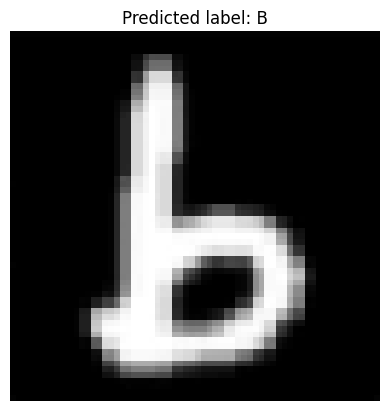

In [35]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)

Saving Screenshot 2024-07-31 184150.png to Screenshot 2024-07-31 184150.png
1/1 [==============================] - 0s 17ms/step
Predicted label for Screenshot 2024-07-31 184150.png: P


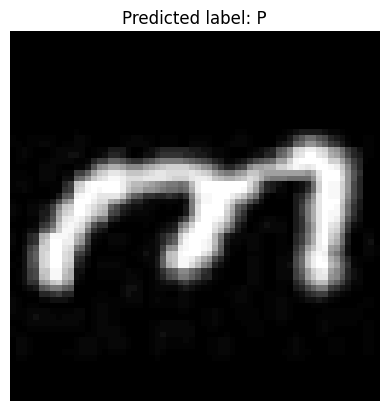

In [36]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)

Saving Screenshot 2024-07-31 183411.png to Screenshot 2024-07-31 183411.png
1/1 [==============================] - 0s 17ms/step
Predicted label for Screenshot 2024-07-31 183411.png: Z


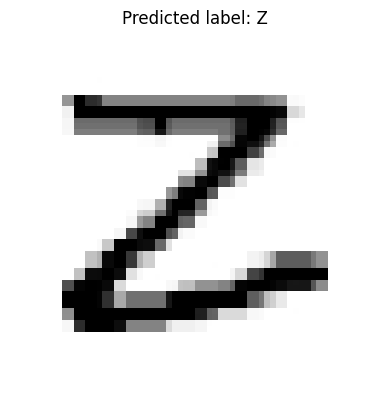

In [37]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)

Saving Screenshot 2024-07-31 181605.png to Screenshot 2024-07-31 181605.png
1/1 [==============================] - 0s 17ms/step
Predicted label for Screenshot 2024-07-31 181605.png: b


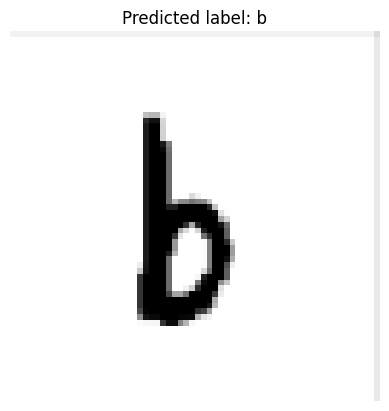

In [38]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)

Saving Screenshot 2024-07-31 191615.png to Screenshot 2024-07-31 191615.png
1/1 [==============================] - 0s 20ms/step
Predicted label for Screenshot 2024-07-31 191615.png: 8


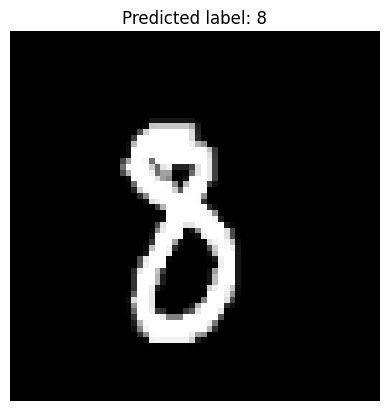

In [40]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
    image_predictor.predict_and_show(uploaded_file)